In [2]:
!pip install wfdb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 88.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


Class Distribution Before Balancing: {'Normal': 0, 'Disease': 23}


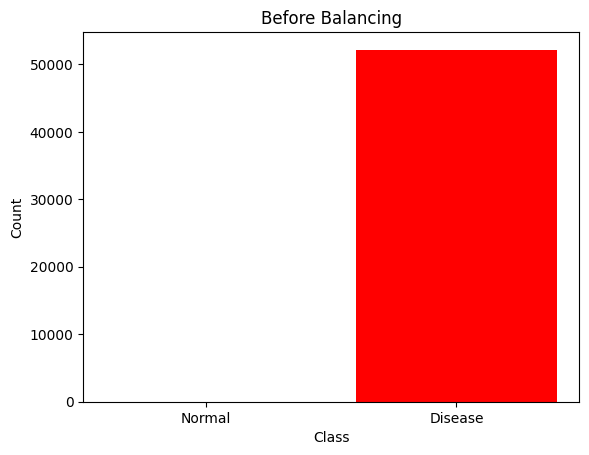

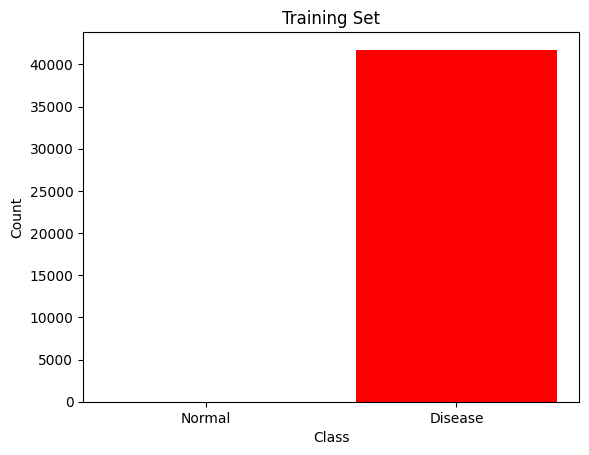

Epoch 1/30
653/653 ━━━━━━━━━━━━━━━━━━━━ 111s 158ms/step - accuracy: 0.9946 - loss: 0.0083 - val_accuracy: 0.7413 - val_loss: 1.0305 - learning_rate: 1.0000e-04
Epoch 2/30
653/653 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 1.0000 - loss: 8.9767e-07 - val_accuracy: 0.9114 - val_loss: 0.2719 - learning_rate: 1.0000e-04
Epoch 3/30
653/653 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 1.0000 - loss: 1.2160e-07 - val_accuracy: 0.9196 - val_loss: 0.2456 - learning_rate: 1.0000e-04
Epoch 4/30
653/653 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 1.0000 - loss: 8.7590e-08 - val_accuracy: 0.9236 - val_loss: 0.2287 - learning_rate: 1.0000e-04
Epoch 5/30
653/653 ━━━━━━━━━━━━━━━━━━━━ 140s 162ms/step - accuracy: 1.0000 - loss: 4.3218e-08 - val_accuracy: 0.9268 - val_loss: 0.2209 - learning_rate: 1.0000e-04
Epoch 6/30
653/653 ━━━━━━━━━━━━━━━━━━━━ 144s 165ms/step - accuracy: 1.0000 - loss: 8.6391e-08 - val_accuracy: 0.9379 - val_loss: 0.1843 - learning_rate: 1.0000e-04
Epoch 7/30
653/653 ━

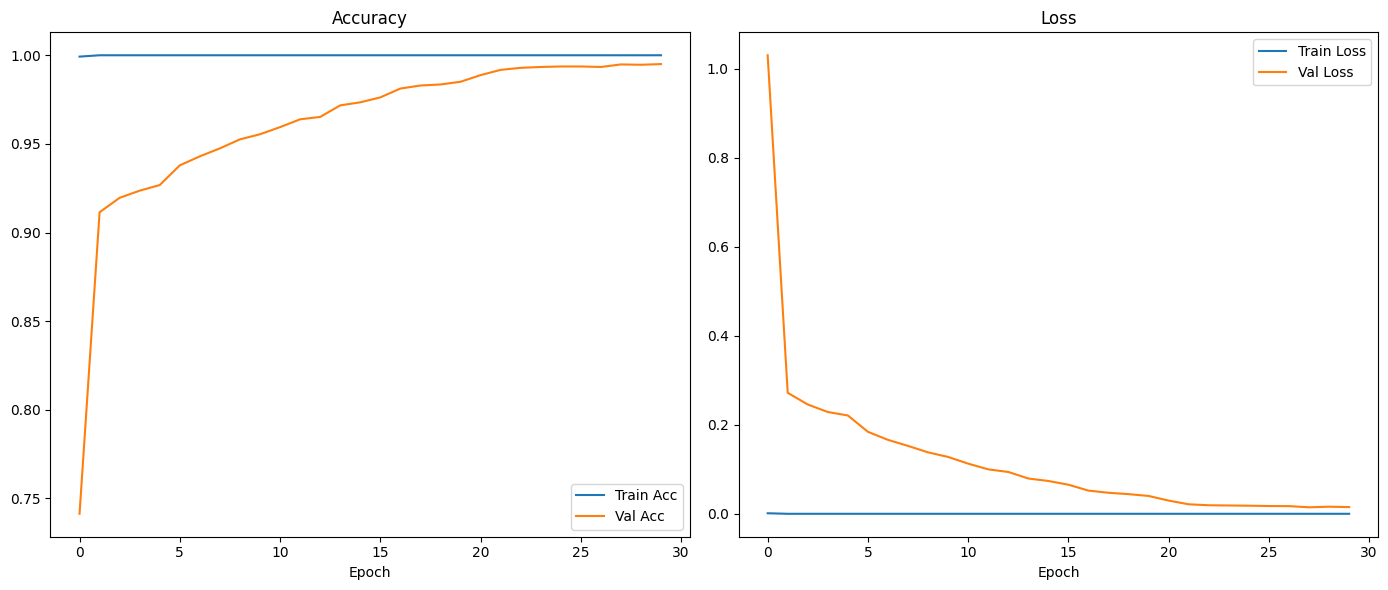

327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step


<ipython-input-6-4098078d3b5e>:123: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('float')/cm.sum(axis=1)[:,None]


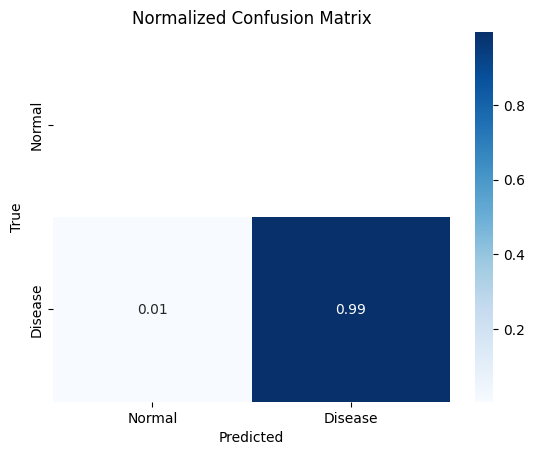

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


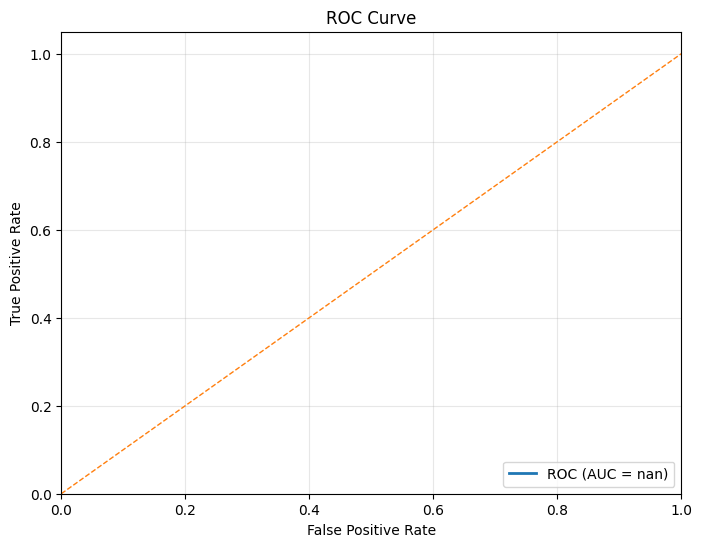

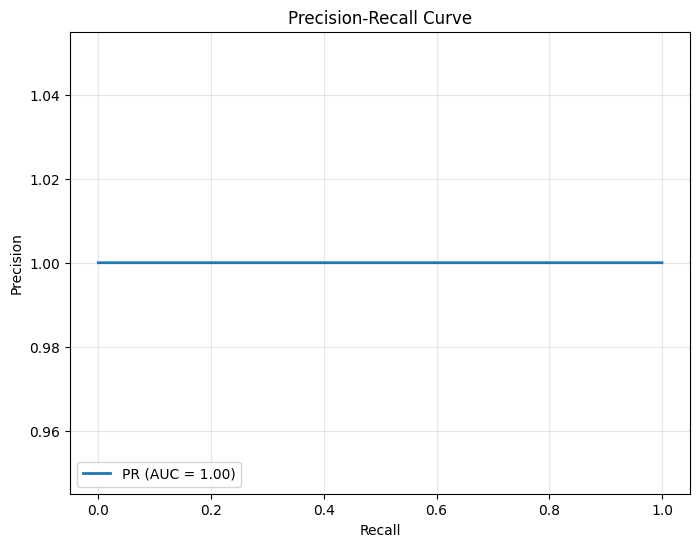

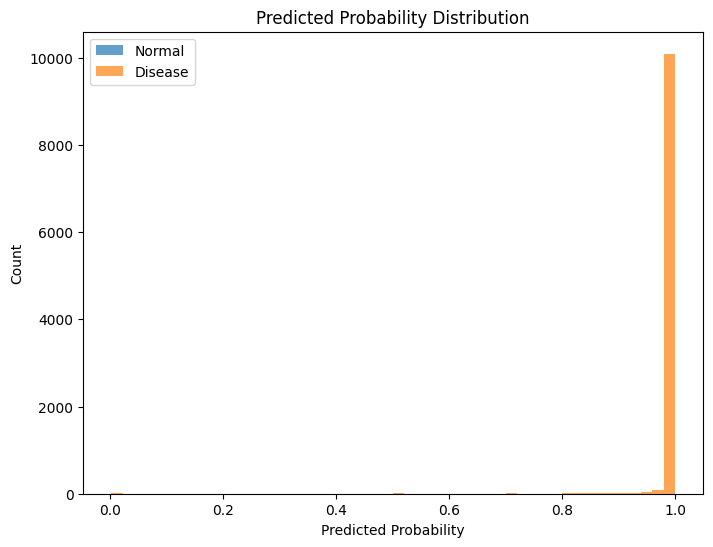

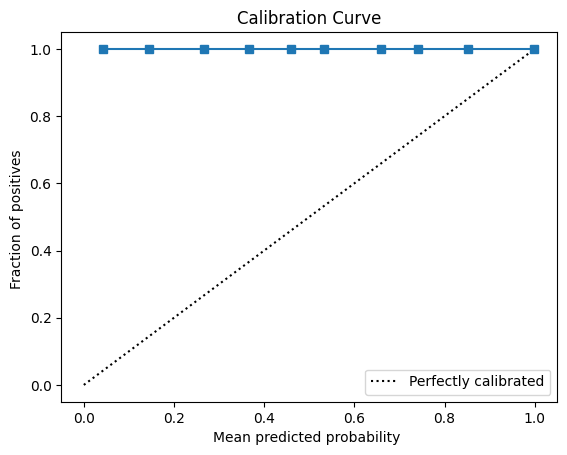

327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step


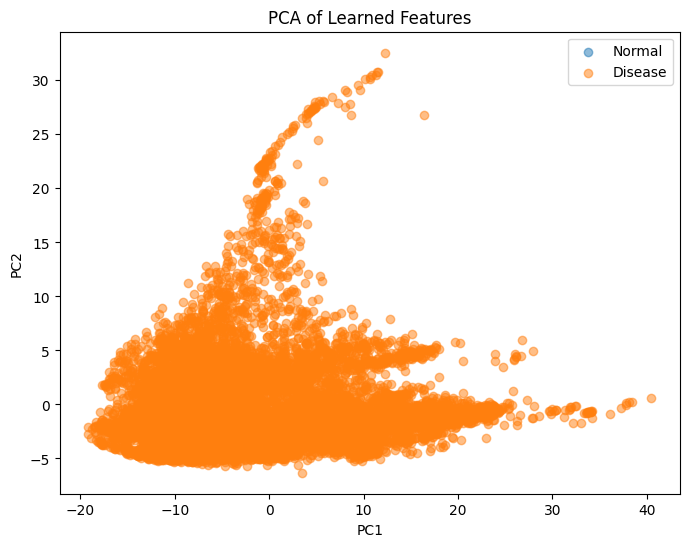


Evaluation Metrics:
F1 Score: 1.00
MCC: 0.00
Balanced Acc: 0.99

Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         0
     Disease       1.00      0.99      1.00     10434

    accuracy                           0.99     10434
   macro avg       0.50      0.50      0.50     10434
weighted avg       1.00      0.99      1.00     10434



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_div

In [6]:
!pip install wfdb
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    balanced_accuracy_score
)
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, Dense,
    Dropout, BatchNormalization, LSTM, Attention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

import scipy.signal as sp

def preprocess_signal(signal, fs=250):
    b, a = sp.butter(1, 0.5 / (fs / 2), btype='highpass')
    filtered = sp.filtfilt(b, a, signal)
    b, a = sp.butter(1, 50 / (fs / 2), btype='lowpass')
    filtered = sp.filtfilt(b, a, filtered)
    return (filtered - np.mean(filtered)) / np.std(filtered)

def preprocess_dataset(files, record_base_path, segment_length=5000):
    X, y = [], []
    dist = {"Normal": 0, "Disease": 0}
    for f in files:
        base = os.path.join(record_base_path, f)
        if not os.path.exists(base + ".dat") or not os.path.exists(base + ".hea"):
            continue
        try:
            rec = wfdb.rdrecord(base)
            sig = preprocess_signal(rec.p_signal[:, 0])
            label = 0 if 'normal' in f.lower() else 1
            dist['Normal' if label == 0 else 'Disease'] += 1
            segs = [
                sig[i:i+segment_length]
                for i in range(0, len(sig)-segment_length, segment_length)
            ]
            if segs:
                X.append(np.array(segs))
                y.extend([label]*len(segs))
        except Exception as e:
            print(f"Error on {base}: {e}")
    print("Class Distribution Before Balancing:", dist)
    X = np.vstack(X)
    y = np.array(y)
    if len(set(y)) < 2:
        tgt = 1 if 0 not in y else 0
        sx, sy = generate_synthetic_data(X, tgt, 10000)
        X = np.vstack((X, sx))
        y = np.concatenate((y, sy))
    return X, y

def generate_synthetic_data(X, target_class, n_samples):
    synth = []
    for _ in range(n_samples):
        s = X[np.random.randint(len(X))].copy()
        s += np.random.normal(0, 0.1, s.shape)
        synth.append(s)
    return np.array(synth), np.array([target_class]*n_samples)

def build_advanced_model(input_shape):
    inp = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.4)(x)
    att = Attention()([x, x])
    x = Flatten()(att)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inp, out)
    model.compile(Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def plot_class_distribution(y, title):
    counts = np.bincount(y)
    plt.bar(['Normal', 'Disease'], counts, color=['blue','red'])
    plt.title(title)
    plt.xlabel('Class'); plt.ylabel('Count')
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cmn = cm.astype('float')/cm.sum(axis=1)[:,None]
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Normal','Disease'],
                yticklabels=['Normal','Disease'])
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0,1],[0,1],'--', lw=1)
    plt.xlim(0,1); plt.ylim(0,1.05)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

def plot_precision_recall_curve(y_true, y_pred_prob):
    p, r, _ = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc(r, p)
    plt.figure(figsize=(8,6))
    plt.plot(r, p, lw=2, label=f'PR (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.show()

def plot_probability_distribution(y_true, y_pred_prob):
    plt.figure(figsize=(8,6))
    plt.hist([
        y_pred_prob[y_true==0],
        y_pred_prob[y_true==1]
    ], bins=50, stacked=True, label=['Normal','Disease'], alpha=0.7)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title('Predicted Probability Distribution')
    plt.legend()
    plt.show()

def plot_calibration_curve(y_true, y_pred_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=n_bins)
    disp = CalibrationDisplay(prob_true, prob_pred, y_pred_prob)
    disp.plot()
    plt.title('Calibration Curve')
    plt.show()

def plot_feature_embedding(model, X, y, layer_name='dense'):
    embed = Model(model.input, model.get_layer(layer_name).output)
    feats = embed.predict(X)
    proj = PCA(2).fit_transform(feats)
    plt.figure(figsize=(8,6))
    plt.scatter(proj[y==0,0], proj[y==0,1], alpha=0.5, label='Normal')
    plt.scatter(proj[y==1,0], proj[y==1,1], alpha=0.5, label='Disease')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title('PCA of Learned Features')
    plt.legend()
    plt.show()

def calculate_metrics(y_true, y_pred):
    print("\nEvaluation Metrics:")
    print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")
    print(f"MCC: {matthews_corrcoef(y_true, y_pred):.2f}")
    print(f"Balanced Acc: {balanced_accuracy_score(y_true, y_pred):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal','Disease']))

def main():
    base = './drive/MyDrive/mit-bih-atrial-fibrillation-database-1.0.0/files/'
    files = [f.split('.')[0] for f in os.listdir(base) if f.endswith('.hea')]
    X, y = preprocess_dataset(files, base)
    plot_class_distribution(y, "Before Balancing")

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    plot_class_distribution(y_train, "Training Set")

    model = build_advanced_model((X_train.shape[1], 1))
    lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30, batch_size=64,
        callbacks=[lr, es]
    )
    plot_training_history(history)

    y_prob = model.predict(X_val).ravel()
    y_pred = (y_prob > 0.5).astype(int)

    plot_confusion_matrix(y_val, y_pred)
    plot_roc_curve(y_val, y_prob)
    plot_precision_recall_curve(y_val, y_prob)
    plot_probability_distribution(y_val, y_prob)
    plot_calibration_curve(y_val, y_prob)
    plot_feature_embedding(model, X_val.reshape(-1, X_val.shape[1], 1), y_val, layer_name='dense')
    plot_model(model, to_file='model_architecture.png', show_shapes=True)

    calculate_metrics(y_val, y_pred)

if __name__ == "__main__":
    main()